# BEAMFORMING

https://pysdr.org/content/doa.html

## Create base signal tx_signal with f = 20kHz
$$ tx\_signal = {e^{j2\pi ft}} = cos(2\pi ft) + j \ sin(2\pi ft) $$ 
<p style="text-align:center;">with<p>

$$ \phi = 0 $$ 

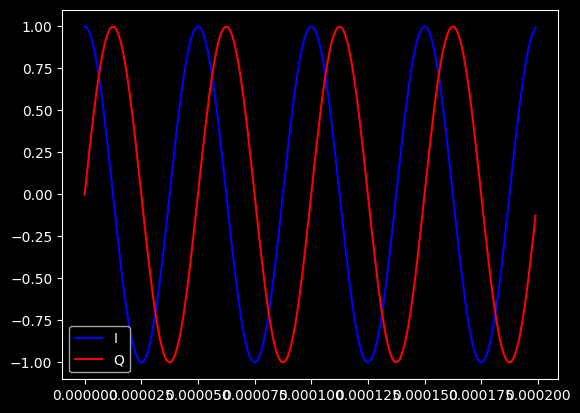

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import beamforming

plt.style.use('dark_background')

sample_rate = 1e6
N = 10000 # number of samples to simulate

# Create a tone to act as the transmitter signal
t = np.arange(N)/sample_rate # time vector
f_tone = 0.02e6
tx_signal = beamforming.create_IQ_signal(f_tone, t)

plt.plot(t[0:200], np.real(tx_signal[0:200]), 'b', label="I")
plt.plot(t[0:200], np.imag(tx_signal[0:200]), 'r', label="Q")
plt.legend()
plt.show()

## Create table of signal phases

In [10]:
antena_spacing = 0.5 # half wavelength spacing
antena_rx_nbr = 5
theta_degrees = 35 # direction of arrival (feel free to change this, it's arbitrary)

theta = np.radians(theta_degrees) # convert to radians

steering_vectors = beamforming.create_steering_vectors(antena_rx_nbr, antena_spacing, theta) # Steering Vector
print(steering_vectors) # note that it's 3 elements long, it's complex, and the first element is 1+0j

[ 1.        +0.j         -0.22909436-0.97340422j -0.89503155+0.44600283j
  0.63918771+0.76905076j  0.60216296-0.7983732j ]


## Multiply each signal reception by phases shift

Complex multioplication is equivalent to add a phase shift

$$
tx_signal = {e^{j2\pi ft}}
steering_vectors = {e^{j2\pi phase_shift}}

steering_vectors * tx_signal = {e^{j2\pi phase_shift}} * {e^{j2\pi ft}} = {e^{j2\pi ft + phase_shift}}

$$



(5, 1)
(1, 10000)
(5, 10000)


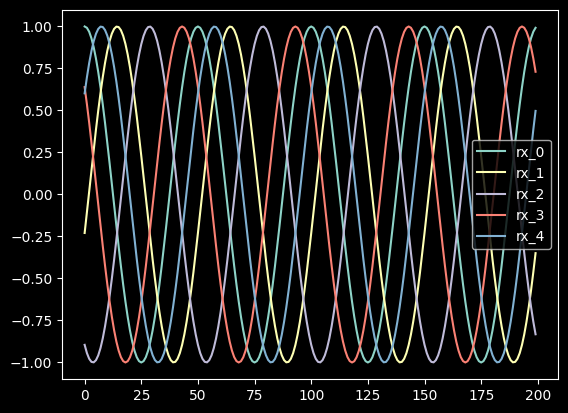

In [11]:
steering_vectors = steering_vectors.reshape(-1,1) # make steering_vectors a column vector
print(steering_vectors.shape) # 3x1
tx_signal = tx_signal.reshape(1,-1) # make tx_signal a row vector
print(tx_signal.shape) # 1x10000

rx_signals = steering_vectors * tx_signal # Simulate the received signal rx_signals through a matrix multiply
print(rx_signals.shape) # 3x10000.  rx_signals is now going to be a 2D array, 1D is time and 1D is the spatial dimension

for rx_signal in range(antena_rx_nbr):
    plt.plot(np.asarray(rx_signals[rx_signal,:]).squeeze().real[0:200], label='rx_' + str(rx_signal))

plt.legend()
plt.show()

## Add some noise

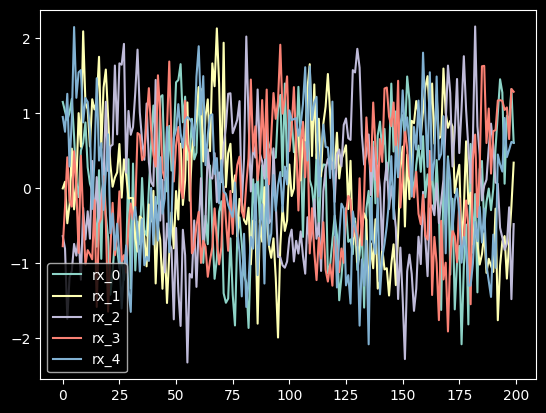

In [12]:
rx_signals = beamforming.generate_noise_on_signal(rx_signals)

for id, rx_signal in enumerate(rx_signals):
    plt.plot(np.asarray(rx_signal).squeeze().real[0:200], label='rx_' + str(id))

plt.legend()
plt.show()

# Create beam from 3 receivers

(1, 10000)


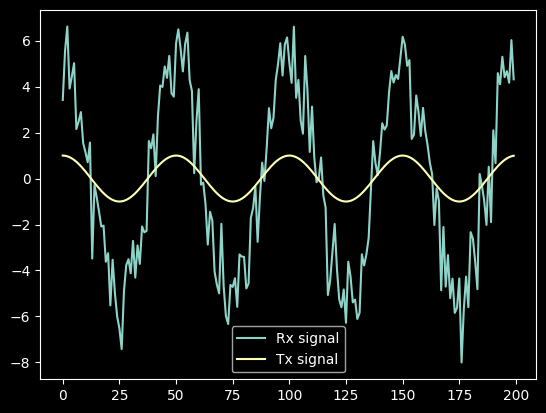

In [13]:
X_weighted = beamforming.beamforming(rx_signals, steering_vectors)
print(X_weighted.shape) # 1x10000
plt.plot(np.asarray(X_weighted).squeeze().real[0:200], label="Rx signal") # the asarray and squeeze are just annoyances we have to do because we came from a matrix
plt.plot(np.asarray(tx_signal).squeeze().real[0:200], label="Tx signal")
plt.legend()
plt.show()

145.04504504504501


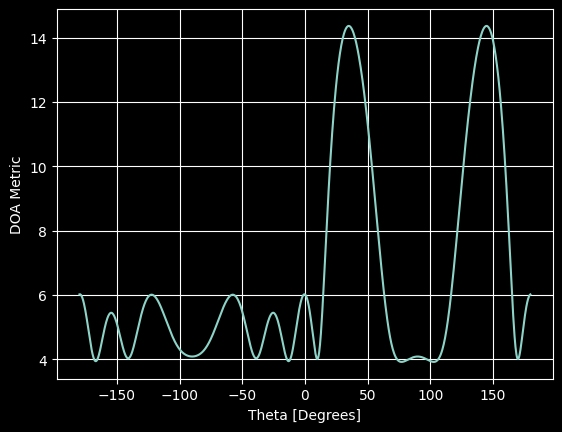

In [16]:
theta_scan = np.linspace(-1*np.pi, np.pi, 1000) # 1000 different thetas between -180 and +180 degrees
results = []
for theta_i in theta_scan:
   w = beamforming.create_steering_vectors(antena_rx_nbr, antena_spacing, theta_i)
   X_weighted = beamforming.beamforming(rx_signals, w)
   results.append(10*np.log10(np.var(X_weighted))) # power in signal, in dB so its easier to see small and large lobes at the same time
results -= np.max(results) # normalize (optional)

# print angle that gave us the max value
print(theta_scan[np.argmax(results)] * 180 / np.pi) # 19.99999999999998

plt.plot(theta_scan*180/np.pi, results) # lets plot angle in degrees 
plt.xlabel("Theta [Degrees]")
plt.ylabel("DOA Metric")
plt.grid()
plt.show()

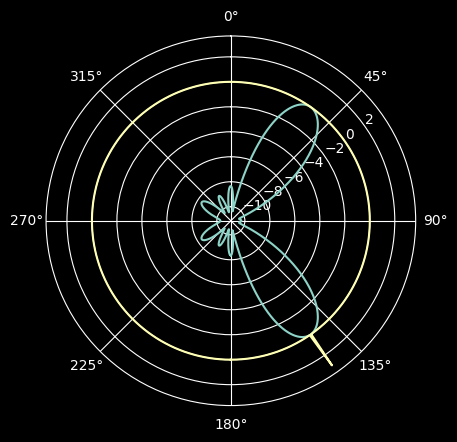

In [15]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_scan, results) # MAKE SURE TO USE RADIAN FOR POLAR
max = theta_scan.copy()
max.fill(0)
l=1000/4
max[np.argmax(results)] = 3
ax.plot(theta_scan, max)
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
plt.show()